# Tutorial 03: road compliance checking

The collision checker library provides a convenient way to construct the road boundary for a scenario and check if the vehicle is within the road.


## 1 Load the scenario

/home/rusinovv/.conda/envs/new9/lib/python3.7/site-packages/commonroad_io-2020.2-py3.7.egg/commonroad/common/file_reader.py:220: UserWarning: Unknown country: Default traffic sign IDs are used.
  warnings.warn("Unknown country: Default traffic sign IDs are used.")
/home/rusinovv/.conda/envs/new9/lib/python3.7/site-packages/commonroad_io-2020.2-py3.7.egg/commonroad/visualization/scenario.py:1012: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  tmp_array  = np.array(list(map(collecting,obj)))


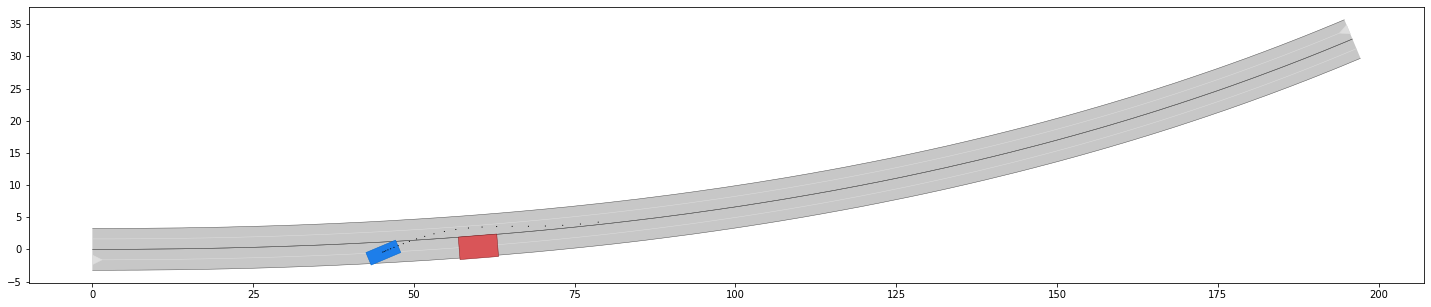

In [1]:
%matplotlib inline
import numpy as np
from time import time
import matplotlib.pyplot as plt

# commonroad
from commonroad.geometry.shape import Polygon, ShapeGroup, Shape, Rectangle
from commonroad.scenario.lanelet import LaneletNetwork
from commonroad.scenario.obstacle import StaticObstacle, ObstacleType
from commonroad.scenario.scenario import Scenario
from commonroad.scenario.trajectory import State
from commonroad.common.file_reader import CommonRoadFileReader

#commonroad_dc
from commonroad_dc.collision.visualization.draw_dispatch import draw_object
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker, create_collision_object
import commonroad_dc.pycrcc as pycrcc
from commonroad_dc.boundary import boundary
from commonroad_dc.collision.trajectory_queries import trajectory_queries
from commonroad_dc.pycrcc.Util import trajectory_enclosure_polygons_static


def open_scenario(scenario_filename):

    crfr = CommonRoadFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set

#open the example scenario
scenario, planning_problem_set = open_scenario("Tut_compliance.xml")


# plot the scenario
plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(planning_problem_set)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()


## 2 Build the road boundary

### 2.1.1 Triangles

0.2550370693206787


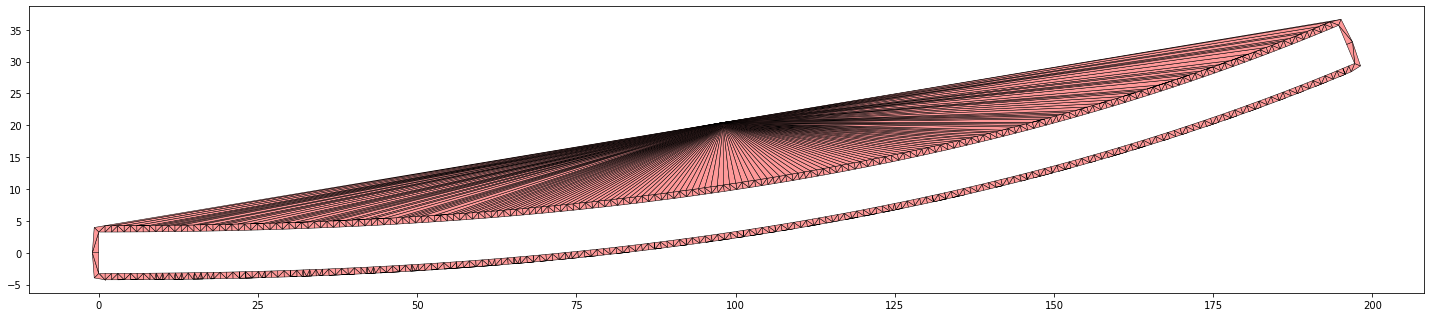

1161


In [2]:
time1=time()
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
time2=time()

print(time2-time1)

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_triangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()
print(road_boundary_sg_triangles.size())



### 2.1.2 Axis-Aligned Triangles (Horizontal)

0.1494913101196289


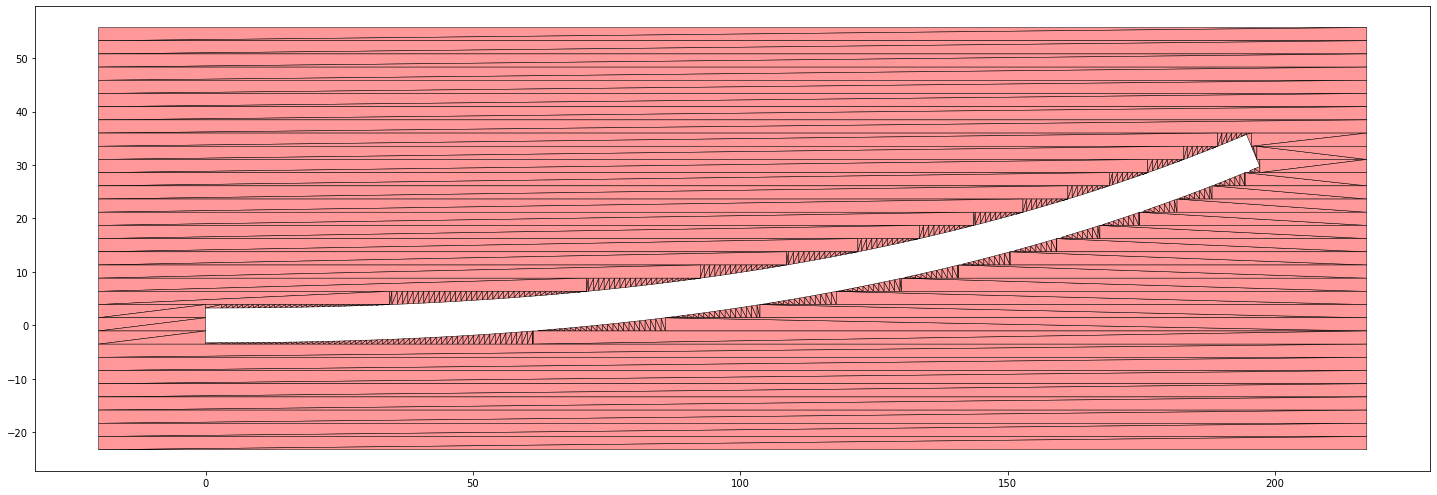

920


In [3]:


time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=1)
time2=time()

print(time2-time1)

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_aligned_triangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

print(road_boundary_sg_aligned_triangles.size())



### 2.1.3 Axis-Aligned Triangles (Vertical)

0.12080645561218262


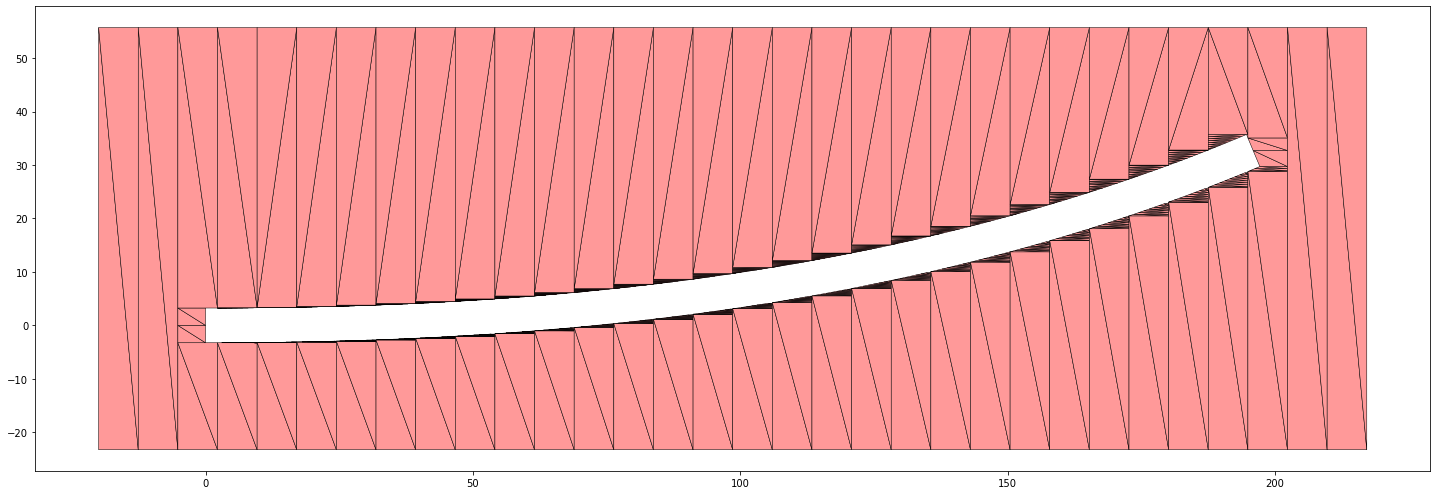

960


In [4]:


time1=time()
road_boundary_obstacle, road_boundary_sg_aligned_triangles=boundary.create_road_boundary_obstacle(scenario, method='aligned_triangulation', axis=2)
time2=time()

print(time2-time1)

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_aligned_triangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

print(road_boundary_sg_aligned_triangles.size())



### 2.2 Rectangles

0.04690718650817871


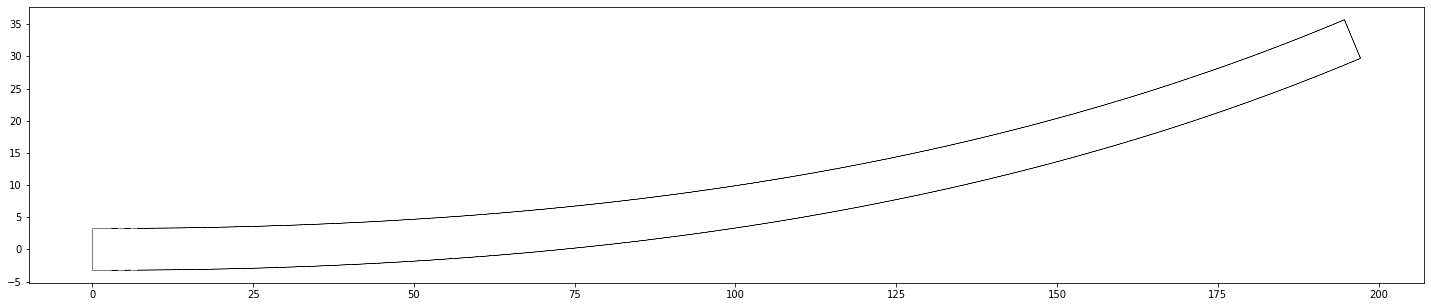

400


In [5]:
time1=time()
road_boundary_obstacle, road_boundary_sg_rectangles=boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles')
time2=time()

print(time2-time1)

# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_rectangles)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

print(road_boundary_sg_rectangles.size())


### 2.3.1 Lane polygons

0.0074160099029541016


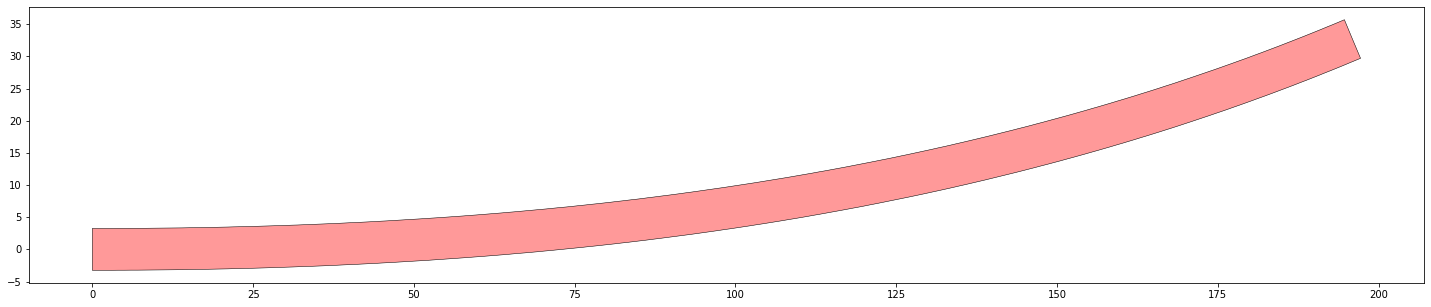

In [6]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='lane_polygons',buffer=1,resample=1, triangulate=False)
time2=time()

print(time2-time1)
# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_polygons)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()


### 2.3.2 Polygons with Holes (Grid)

0.018941164016723633


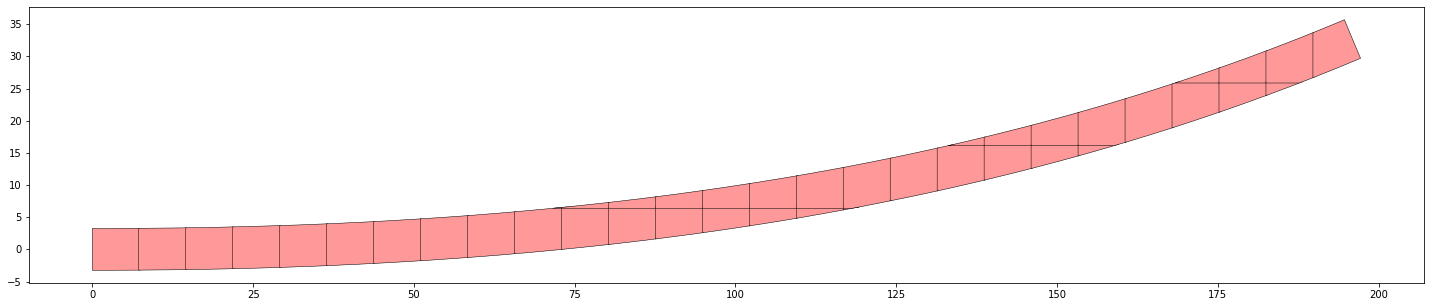

In [7]:

# length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2
# width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

time1=time()
road_boundary_sg_polygons_grid=boundary.create_road_polygons(scenario, method='whole_polygon_tiled', max_cell_width=car_half_length*3, max_cell_height=car_half_length*5,triangulate=False)
time2=time()

print(time2-time1)
# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_polygons_grid)
#for poly in road_boundary_sg_polygons.unpack():
#    draw_object(poly.triangle_mesh())

plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

### 2.3.3 Polygon with Holes

0.0011048316955566406


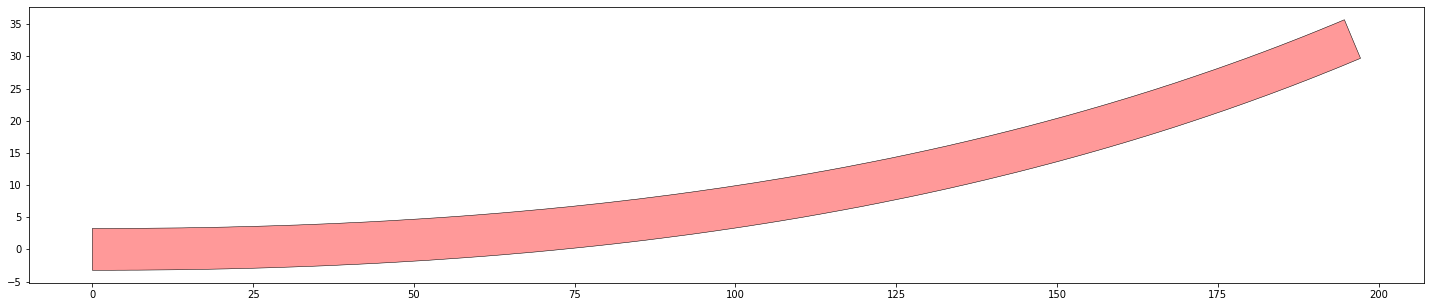

In [8]:
time1=time()
road_boundary_sg_polygons=boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)
time2=time()

print(time2-time1)
# draw the road boundary
plt.figure(figsize=(25, 10))
draw_object(road_boundary_sg_polygons)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

## Check if the trajectory is within the road

### Select part of the trajectory for compliance checks

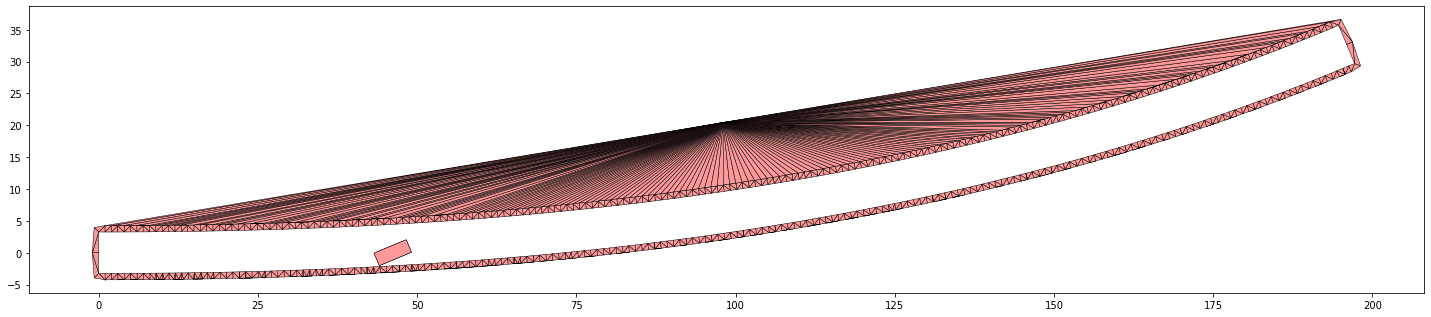

In [9]:
import commonroad_dc.pycrcc as pycrcc

start_step=3

# half-length of the ego-vehicle
car_half_length=scenario.dynamic_obstacles[0].prediction.shape.length/2

# half-width of the ego-vehicle
car_half_width=scenario.dynamic_obstacles[0].prediction.shape.width/2

#list with trajectory states that are checked for collisions with the road boudnary
traj_list=list()
state_list=scenario.dynamic_obstacles[0].prediction.trajectory.state_list

# add all trajectory steps from start_step onwards into traj_list
for el in state_list[start_step:]:

    new_el=list()
    new_el.append(el.position[0])
    new_el.append(el.position[1])
    new_el.append(el.orientation)
    traj_list.append(new_el)
    
#draw the ego-vehicle at Step i of the traj_list
i=0
obb=pycrcc.RectOBB(car_half_length,car_half_width , traj_list[i][2],traj_list[i][0],traj_list[i][1])
obb_next=pycrcc.RectOBB(car_half_length,car_half_width , traj_list[i+1][2],traj_list[i+1][0],traj_list[i+1][1])

obb_merged=obb.merge(obb_next)


# draw the road boundary
plt.figure(figsize=(25, 25))
draw_object(road_boundary_sg_triangles)
#draw_object(road_boundary_sg_polygons)


draw_object(obb)
draw_object(obb_next)
draw_object(obb_merged)

#plt.ylim(-7,12)
#plt.xlim(25,75)

plt.autoscale()
plt.gca().set_aspect('equal')

plt.show()


In [10]:
def create_tvobstacle(traj_list,car_half_length,car_half_width):
    retObj=pycrcc.TimeVariantCollisionObject(0)
    for time_step in traj_list:
        retObj.append_obstacle(pycrcc.RectOBB(car_half_length, car_half_width, time_step[2],time_step[0],time_step[1]))
    return retObj    
    
    
co=create_tvobstacle(traj_list,car_half_length,car_half_width)

In [11]:
preprocessed_trajectories=list()
trajectories_first_object=list()
for el in range(1000):
    trajectories_first_object.append(traj_list[start_step:start_step])
cur_time_1=time()
for el in range(1000):
    traj, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
    if(err):
        raise Exception("trajectory preprocessing error")
    preprocessed_trajectories.append(traj)

cur_time_2 = time()

print('trajectory preprocessing time (OBB sum hull) for 1000 trajectories: ' + str(cur_time_2-cur_time_1))

trajectory preprocessing time (OBB sum hull) for 1000 trajectories: 0.013991355895996094


### Method 1: Collision Checks - triangles

In [12]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(trajectories_first_object):
        if trajectory_enclosure_polygons_static(road_boundary_sg_polygons,car_half_length, car_half_width, el)==-1:    
            candidate_trajectories.append(preprocessed_trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_aligned_triangles, method='grid', num_cells=32, auto_orientation=True)

    
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


Time for 1000 trajectory checks: 0.013314080238342286 sec.


### Method 2: Polygon enclosure checks

In [13]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(preprocessed_trajectories):
        candidate_trajectories.append(el)
    ret=trajectory_queries.trajectories_enclosure_polygons_static(candidate_trajectories, road_boundary_sg_polygons_grid, method='grid', num_cells=32, enable_verification=False)

cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

Time for 1000 trajectory checks: 0.1151425838470459 sec.


### Method 3: OBB-rectangle boundary

In [14]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(trajectories_first_object):
        if trajectory_enclosure_polygons_static(road_boundary_sg_polygons,car_half_length, car_half_width, el)==-1:    
            candidate_trajectories.append(preprocessed_trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True)

    
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


Time for 1000 trajectory checks: 0.009885334968566894 sec.
